1. Imports

In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [133]:
df = pd.read_csv('X:\Projects\mlproject2\MVP\data2.csv')

In [134]:
print(df.head())
print(df.shape)

   bathrooms state  isFeatured  isPremierBuilder  isShowcaseListing  \
0          1    RI       False             False              False   
1          1    RI       False             False              False   
2          1    RI       False             False              False   
3          2    RI       False             False              False   
4          2    RI       False             False              False   

   isPreforeclosureAuction  longitude  isNonOwnerOccupied lotAreaUnit  \
0                    False -71.733450                True       acres   
1                    False -71.148420                True       acres   
2                    False -71.233130                True       acres   
3                    False -71.192825                True       acres   
4                    False -71.759650                True       acres   

   lotAreaValue homeStatus  daysOnZillow   latitude country  bedrooms  \
0      2.800000   FOR_SALE            -1  41.418095     USA  

2. Finding and dropping useless columns

In [135]:
# Check for missing values
df.isna().sum()

bathrooms                    0
state                        0
isFeatured                   0
isPremierBuilder             0
isShowcaseListing            0
isPreforeclosureAuction      0
longitude                    4
isNonOwnerOccupied           0
lotAreaUnit                 24
lotAreaValue                24
homeStatus                   0
daysOnZillow                 0
latitude                     4
country                      0
bedrooms                     0
livingArea                   0
streetAddress                0
isZillowOwned                0
shouldHighlight              0
zpid                         0
homeStatusForHDP             0
isUnmappable                 0
listing_sub_type             0
city                         0
price                        0
homeType                     0
currency                     0
zipcode                      0
priceForHDP                  0
taxAssessedValue            97
rentZestimate              339
zestimate                  384
priceCha

In [136]:
# Drop irrelevant columns

cols_to_drop = ['state', 'isFeatured', 'isPremierBuilder', 'isShowcaseListing',
                'isPreforeclosureAuction', 'isNonOwnerOccupied', 'homeStatus', 'daysOnZillow', 'country',
                'isUnmappable', 'streetAddress', 'isZillowOwned', 'shouldHighlight', 'zpid', 'homeStatusForHDP',
                'listing_sub_type', 'datePriceChanged', 'currency', 'priceForHDP', 'open_house_info', 'openHouse', 'unit']

coordinates = df[['longitude', 'latitude']]

cols_to_drop.extend(['longitude', 'latitude'])

# Drop columns containing >50% missing values
for i in range(len(df.columns)):
    if df[df.columns[i]].isna().sum() > len(df)//2:
        cols_to_drop.append(df.columns[i])

print(cols_to_drop)

['state', 'isFeatured', 'isPremierBuilder', 'isShowcaseListing', 'isPreforeclosureAuction', 'isNonOwnerOccupied', 'homeStatus', 'daysOnZillow', 'country', 'isUnmappable', 'streetAddress', 'isZillowOwned', 'shouldHighlight', 'zpid', 'homeStatusForHDP', 'listing_sub_type', 'datePriceChanged', 'currency', 'priceForHDP', 'open_house_info', 'openHouse', 'unit', 'longitude', 'latitude', 'priceChange', 'datePriceChanged', 'priceReduction', 'unit', 'open_house_info', 'openHouse', 'videoCount', 'newConstructionType', 'priceSuffix', 'group_type', 'providerListingID']


In [137]:
"""
# Test cols to drop on a test_df
temp_df = df.copy()
temp_df = temp_df.drop(columns = cols_to_drop)
print(temp_df.columns)
"""

'\n# Test cols to drop on a test_df\ntemp_df = df.copy()\ntemp_df = temp_df.drop(columns = cols_to_drop)\nprint(temp_df.columns)\n'

In [138]:
df = df.drop(columns = cols_to_drop)
print(df.columns)

Index(['bathrooms', 'lotAreaUnit', 'lotAreaValue', 'bedrooms', 'livingArea',
       'city', 'price', 'homeType', 'zipcode', 'taxAssessedValue',
       'rentZestimate', 'zestimate'],
      dtype='object')


3. Classify the features in the df into numerical, categorical and misc

In [139]:
# organize into numerical, categorical, geo features
categorical_features = [feature for feature in df.columns if df[feature].dtypes == 'O']
numerical_features = [feature for feature in df.columns if df[feature].dtypes != 'O']

In [140]:
categorical_features.append('zipcode')
numerical_features.remove('zipcode')

print(coordinates, numerical_features, categorical_features)


     longitude   latitude
0   -71.733450  41.418095
1   -71.148420  41.634296
2   -71.233130  41.530296
3   -71.192825  41.673626
4   -71.759650  41.916225
..         ...        ...
815 -71.273340  41.672626
816 -71.474780  41.969883
817 -71.483406  41.365925
818 -71.597940  41.369637
819 -71.445600  41.837112

[820 rows x 2 columns] ['bathrooms', 'lotAreaValue', 'bedrooms', 'livingArea', 'price', 'taxAssessedValue', 'rentZestimate', 'zestimate'] ['lotAreaUnit', 'city', 'homeType', 'zipcode']


In [141]:
discrete_features = [feature for feature in numerical_features if df[feature].nunique() < 20]
continuous_features = [feature for feature in numerical_features if df[feature].nunique() >= 20]
print(discrete_features, continuous_features)

['bathrooms', 'bedrooms'] ['lotAreaValue', 'livingArea', 'price', 'taxAssessedValue', 'rentZestimate', 'zestimate']


4. Do a train test split

In [142]:
# Do a train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, df['price'], test_size=0.2, random_state=42)

In [143]:
print(X_train.shape, X_test.shape ,y_train.shape, y_test.shape)

(656, 12) (164, 12) (656,) (164,)


In [144]:
print(X_train.head())
print(y_train.head())

print(X_test.head())
print(y_test.head())

     bathrooms lotAreaUnit  lotAreaValue  bedrooms  livingArea        city  \
174          2       acres      0.469995         4        1835  Smithfield   
244          1        sqft  10852.000000         4        1804     Warwick   
453          3        sqft   8276.000000         4        3270  Providence   
356          3       acres      0.919995         3        1820    Johnston   
499          3        sqft   5175.000000         4        1965  Providence   

       price       homeType  zipcode  taxAssessedValue  rentZestimate  \
174   529000  SINGLE_FAMILY     2917          277500.0         2999.0   
244   429900  SINGLE_FAMILY     2889          221700.0         2996.0   
453  1875000  SINGLE_FAMILY     2906          654300.0         6666.0   
356   589900  SINGLE_FAMILY     2919               NaN            NaN   
499   340000  SINGLE_FAMILY     2905          175300.0         2857.0   

     zestimate  
174   531200.0  
244   445300.0  
453  1814800.0  
356        NaN  
499   3

5. Handle missing values - categorical

In [145]:
# Missing values of categorical features of X_train
categorical_nan = [feature for feature in categorical_features if X_train[feature].isnull().sum()>1]

In [146]:
print(categorical_nan)

['lotAreaUnit']


In [147]:
# Fill in missing categorical values with 'missing'. We can do this for both X_train and X_test
X_train[categorical_nan] = X_train[categorical_nan].fillna('missing')
X_test[categorical_nan] = X_test[categorical_nan].fillna('missing')


In [148]:
print(X_train[categorical_nan])
print(X_test[categorical_nan])

    lotAreaUnit
174       acres
244        sqft
453        sqft
356       acres
499        sqft
..          ...
71        acres
106       acres
270       acres
435       acres
102        sqft

[656 rows x 1 columns]
    lotAreaUnit
641       acres
333        sqft
67        acres
682        sqft
398       acres
..          ...
208       acres
210        sqft
447        sqft
764        sqft
667       acres

[164 rows x 1 columns]


5. Handle missing values - numerical features 

In [149]:
# Handle missing values of numerical features of X_train
numerical_nan = [feature for feature in numerical_features if X_train[feature].isnull().sum()>1]

In [150]:
print(numerical_nan)

['lotAreaValue', 'taxAssessedValue', 'rentZestimate', 'zestimate']


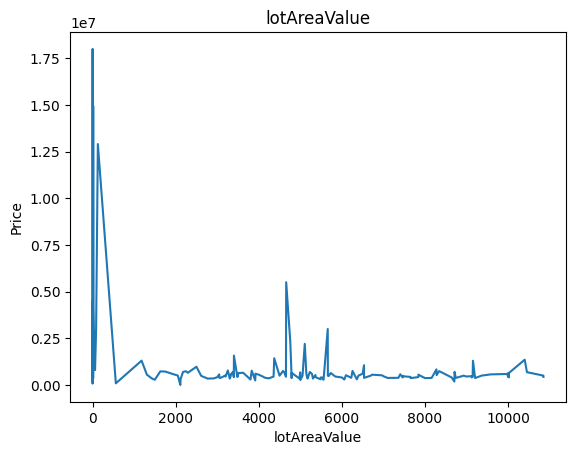

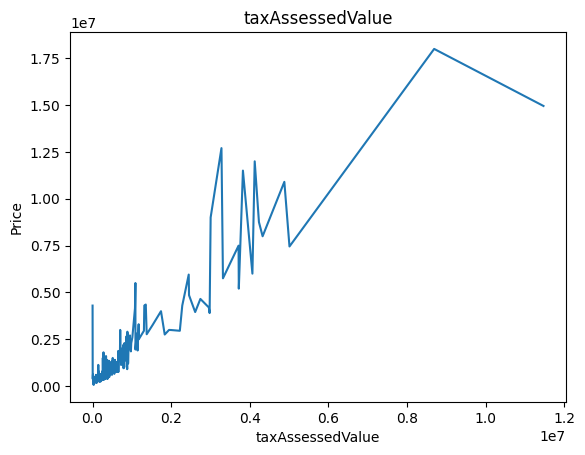

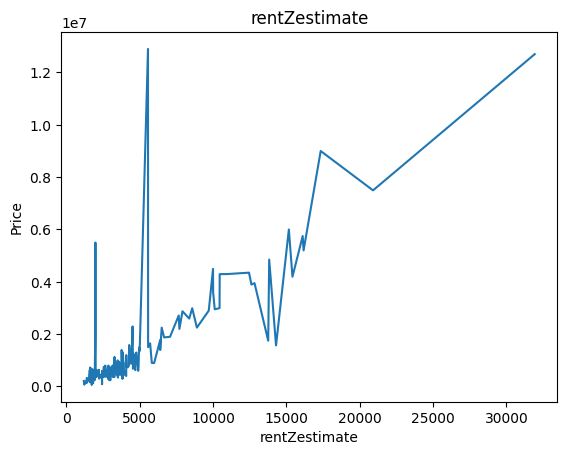

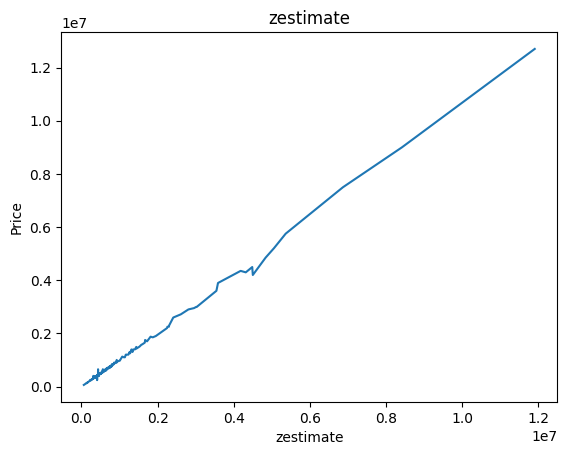

In [151]:
for feature in numerical_nan:
    # Create a new feature to mark the presence of Nan values
    X_train[feature + 'nan'] = np.where(X_train[feature].isna(), 1, 0)

    temp_data = X_train.copy()
    # Group X_train by the (missing) feature
    temp_data = temp_data.groupby(feature)
    # Calculate mean price where the info is missing or present. Plot the mean price vs the feature
    temp_data['price'].mean().plot.line()
    plt.ylabel('Price')
    plt.title(feature)
    plt.show()

From the above plots, we can see that the price increases with the increase in taxAssessedValue, rentZestimate and zestimate.
Price does not have any correlation with lotAreaValue.

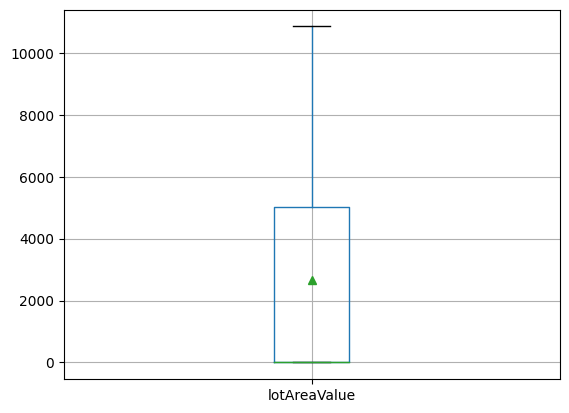

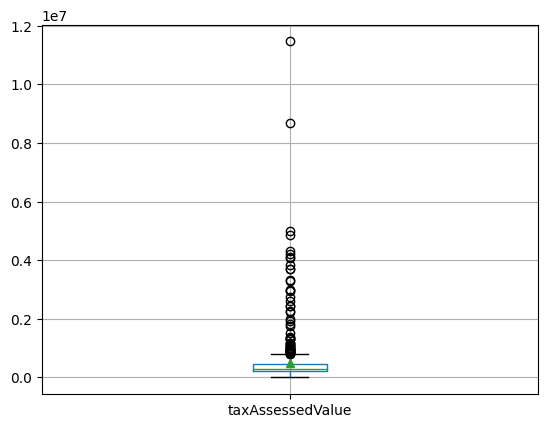

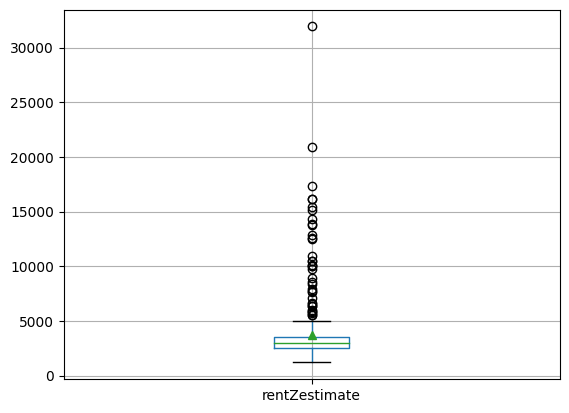

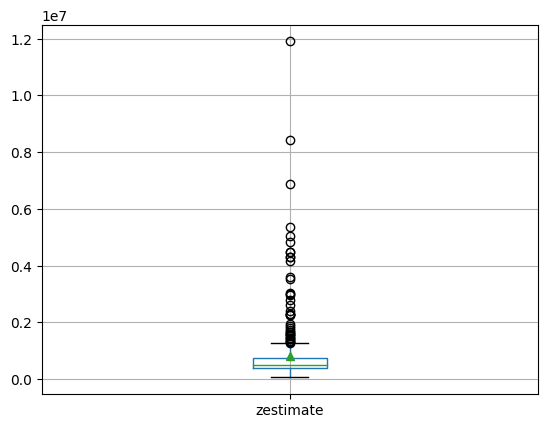

In [152]:
# Make a box plot to check for outliers in the features with missing entries

for feature in numerical_nan:
    #log_feature = np.log(X_train[feature]).to_frame()
    X_train[feature].to_frame().boxplot(showmeans=True)
    #plt.title(feature)
    plt.show()

There are outliers in taxAssessedValue, rentzestimate, zestimate

In [153]:
# Lets impute the ones with outliers with median, and the others with mean
outliers = ['taxAssessedValue', 'rentzestimate', 'zestimate']

for feature in numerical_nan:
    if feature in outliers:
        median_value = X_train[feature].median()
        X_train[feature].fillna(median_value, inplace = True)

    else:
        mean_value = X_train[feature].mean()
        X_train[feature].fillna(mean_value, inplace = True)

X_train[numerical_nan].isna().sum()

lotAreaValue        0
taxAssessedValue    0
rentZestimate       0
zestimate           0
dtype: int64

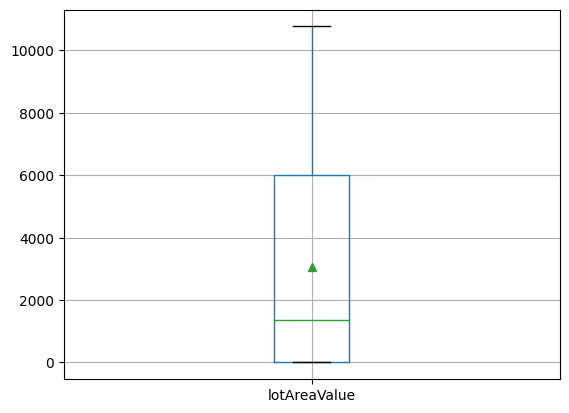

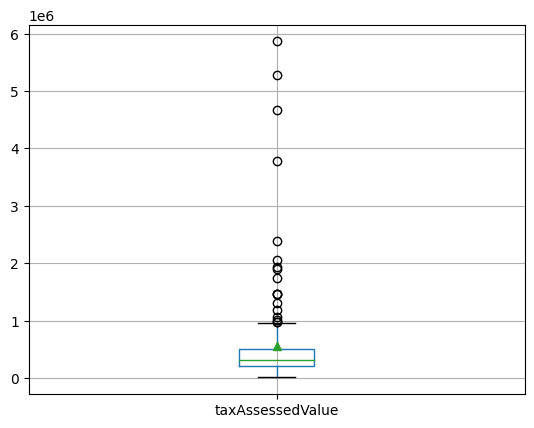

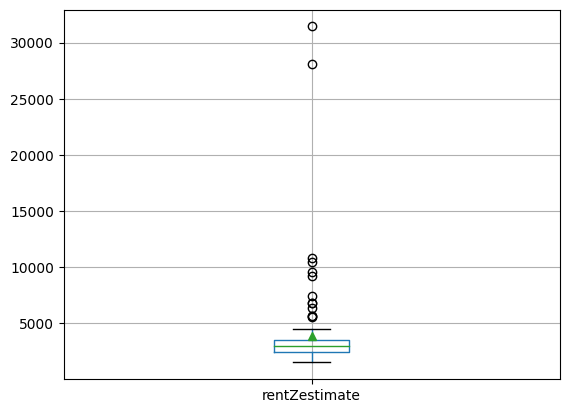

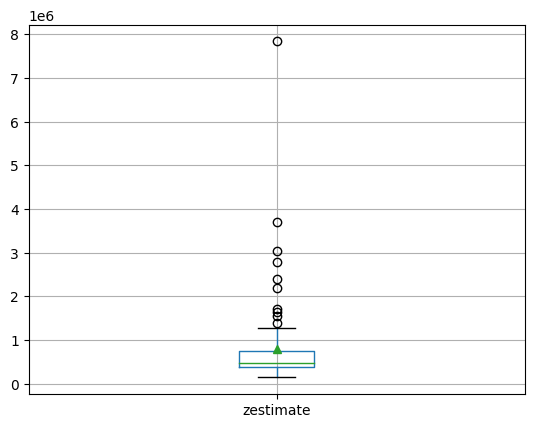

In [154]:
# Repeat above process for X_test
numerical_nan_test = [feature for feature in numerical_features if X_test[feature].isnull().sum()>1]

for feature in numerical_nan_test:
    X_test[feature + 'nan'] = np.where(X_test[feature].isna(), 1, 0)
    X_test[feature].to_frame().boxplot(showmeans=True)
    #plt.ylabel(feature)
    #plt.title(feature)
    plt.show()

In [155]:
# Repeat above process for X_test
outliers = ['taxAssessedValue', 'rentzestimate', 'zestimate']

for feature in numerical_nan:
    if feature in outliers:
        median_value = X_test[feature].median()
        X_test[feature].fillna(median_value, inplace = True)

    else:
        mean_value = X_test[feature].mean()
        X_test[feature].fillna(mean_value, inplace = True)

X_test[numerical_nan].isna().sum()

lotAreaValue        0
taxAssessedValue    0
rentZestimate       0
zestimate           0
dtype: int64

In [156]:
X_test.head()
X_train.head()

,bathrooms,lotAreaUnit,lotAreaValue,bedrooms,livingArea,city,price,homeType,zipcode,taxAssessedValue,rentZestimate,zestimate,lotAreaValuenan,taxAssessedValuenan,rentZestimatenan,zestimatenan
174,2,acres,0.469995,4,1835,Smithfield,529000,SINGLE_FAMILY,2917,277500.0,2999.000000,531200.0,0,0,0,0
244,1,sqft,10852.000000,4,1804,Warwick,429900,SINGLE_FAMILY,2889,221700.0,2996.000000,445300.0,0,0,0,0
453,3,sqft,8276.000000,4,3270,Providence,1875000,SINGLE_FAMILY,2906,654300.0,6666.000000,1814800.0,0,0,0,0
356,3,acres,0.919995,3,1820,Johnston,589900,SINGLE_FAMILY,2919,289700.0,3677.005222,508300.0,0,1,1,1
499,3,sqft,5175.000000,4,1965,Providence,340000,SINGLE_FAMILY,2905,175300.0,2857.000000,359100.0,0,0,0,0


6. Check the distribution of continuous numerical features

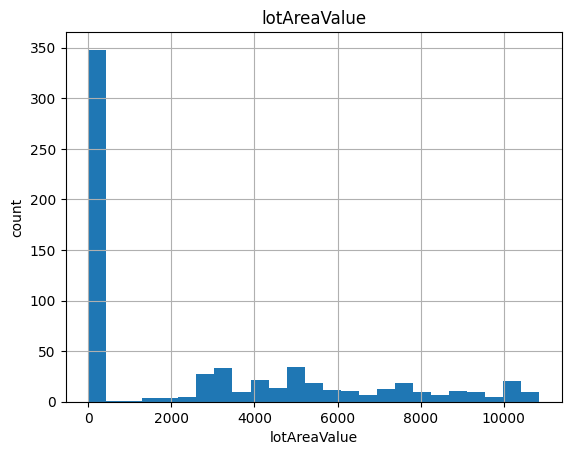

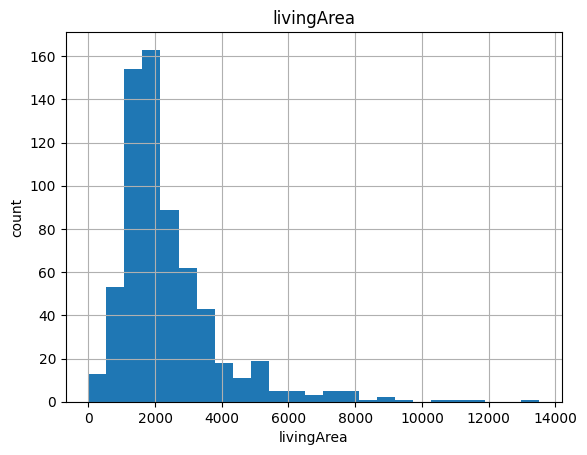

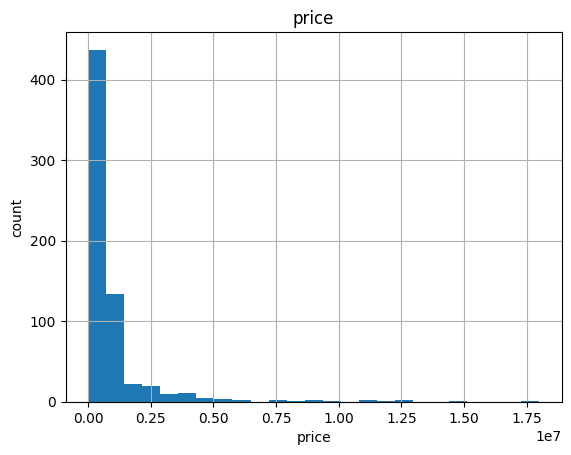

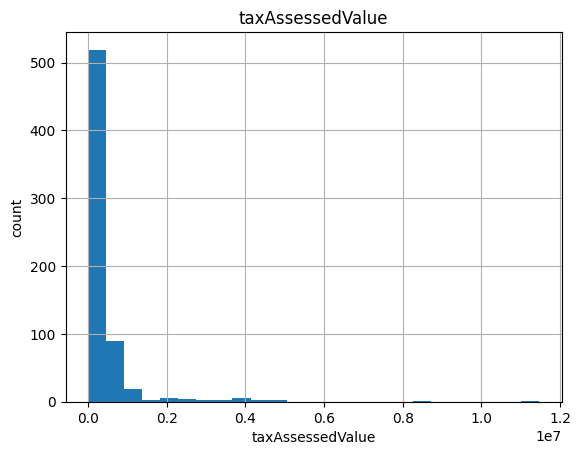

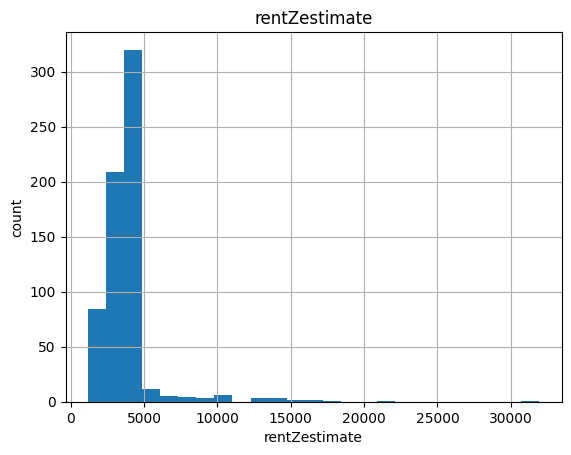

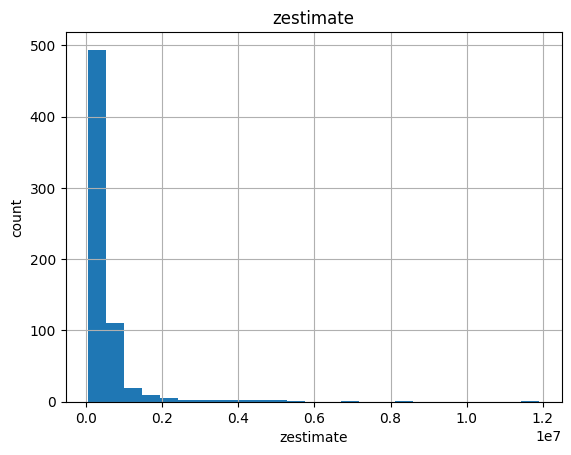

In [157]:
# Check if continuous features are gaussian or not - do this on X_train and X_test
# Linear regression requires gaussian
for feature in continuous_features:
    temp_data = X_train.copy()
    temp_data[feature].hist(bins = 25)
    plt.xlabel(feature)
    plt.ylabel("count") 
    plt.title(feature)
    plt.show()

In [158]:
"""
# Applying logarithmic transformation. This makes the distributions 'more gaussian'
for feature in continuous_features:
    temp_data = X_train.copy()
    if 0 in temp_data[feature].unique():
        pass
    else:
        temp_data[feature] = np.log(temp_data[feature])
        temp_data['price'] = np.log(temp_data['price'])
        plt.scatter(temp_data[feature], temp_data['price'])
        plt.xlabel(feature)
        plt.xlabel('Price')
        plt.title(feature)
        plt.show()
"""

"\n# Applying logarithmic transformation. This makes the distributions 'more gaussian'\nfor feature in continuous_features:\n    temp_data = X_train.copy()\n    if 0 in temp_data[feature].unique():\n        pass\n    else:\n        temp_data[feature] = np.log(temp_data[feature])\n        temp_data['price'] = np.log(temp_data['price'])\n        plt.scatter(temp_data[feature], temp_data['price'])\n        plt.xlabel(feature)\n        plt.xlabel('Price')\n        plt.title(feature)\n        plt.show()\n"

Lot Area value is still not gaussian. So linear regression may not be effective. Use other approaches

7. Handle rare categorical features - with less than 1% of entries

In [159]:
"""
# Before doing this, lets edit the 'street address' to just street name
# testing on temp_df
temp_df = X_train.copy()

for i, a in temp_df['streetAddress'].items():
    parts = a.split()
    #print(i, parts)
    temp_df.at[i, a] = ' '.join(parts[1:])
    print(temp_df.at[i, a])

temp_df['streetAddress'].nunique()
"""

"\n# Before doing this, lets edit the 'street address' to just street name\n# testing on temp_df\ntemp_df = X_train.copy()\n\nfor i, a in temp_df['streetAddress'].items():\n    parts = a.split()\n    #print(i, parts)\n    temp_df.at[i, a] = ' '.join(parts[1:])\n    print(temp_df.at[i, a])\n\ntemp_df['streetAddress'].nunique()\n"

In [160]:
# Replace rare categories with 'rare'
for feature in categorical_features:
    temp = X_train.groupby(feature)['price'].count()/len(X_train)
    temp_df = temp[temp>0.01].index
    X_train[feature] = np.where(X_train[feature].isin(temp_df), X_train[feature], 'Rare_var')
    #print(X_train[feature])

    temp = X_test.groupby(feature)['price'].count()/len(X_test)
    temp_df = temp[temp>0.01].index
    X_test[feature] = np.where(X_test[feature].isin(temp_df), X_test[feature], 'Rare_var')
    #print(X_test[feature])

8. Encoding categorical features

In [161]:
temp_df = X_train.copy()
print(temp_df.shape)
encoder = ce.BinaryEncoder(cols = categorical_features)
temp_df = encoder.fit_transform(temp_df)

(656, 16)


In [162]:
# Applying binary encoding to X_train and X_test
encoder = ce.BinaryEncoder(cols = categorical_features)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)
print(X_test.head())
print(X_train.head())

     bathrooms  lotAreaUnit_0  lotAreaUnit_1  lotAreaValue  bedrooms  \
641          2              0              1      0.780028         3   
333          2              1              0   5663.000000         4   
67           2              0              1      0.289991         4   
682          1              1              0   6098.000000         2   
398          3              0              1     17.190000         4   

     livingArea  city_0  city_1  city_2  city_3  city_4  city_5     price  \
641        1316       0       0       1       1       1       1    455000   
333        2250       0       0       1       1       0       0    575000   
67         1547       0       0       0       1       0       1    374900   
682        1633       0       1       1       0       1       0    825000   
398        3574       0       1       0       1       0       1  13500000   

     homeType_0  homeType_1  homeType_2  zipcode_0  zipcode_1  zipcode_2  \
641           0           0 

In [163]:
print(X_test.columns)
print(X_train.columns)

Index(['bathrooms', 'lotAreaUnit_0', 'lotAreaUnit_1', 'lotAreaValue',
       'bedrooms', 'livingArea', 'city_0', 'city_1', 'city_2', 'city_3',
       'city_4', 'city_5', 'price', 'homeType_0', 'homeType_1', 'homeType_2',
       'zipcode_0', 'zipcode_1', 'zipcode_2', 'zipcode_3', 'zipcode_4',
       'zipcode_5', 'taxAssessedValue', 'rentZestimate', 'zestimate',
       'lotAreaValuenan', 'taxAssessedValuenan', 'rentZestimatenan',
       'zestimatenan'],
      dtype='object')
Index(['bathrooms', 'lotAreaUnit_0', 'lotAreaUnit_1', 'lotAreaValue',
       'bedrooms', 'livingArea', 'city_0', 'city_1', 'city_2', 'city_3',
       'city_4', 'city_5', 'price', 'homeType_0', 'homeType_1', 'homeType_2',
       'zipcode_0', 'zipcode_1', 'zipcode_2', 'zipcode_3', 'zipcode_4',
       'zipcode_5', 'taxAssessedValue', 'rentZestimate', 'zestimate',
       'lotAreaValuenan', 'taxAssessedValuenan', 'rentZestimatenan',
       'zestimatenan'],
      dtype='object')


9. Feature scaling

In [164]:
"""
scaler = MinMaxScaler()
temp_df = X_train.copy()

temp_df = scaler.fit_transform(temp_df)
print(temp_df)
"""

'\nscaler = MinMaxScaler()\ntemp_df = X_train.copy()\n\ntemp_df = scaler.fit_transform(temp_df)\nprint(temp_df)\n'

In [165]:
"""
temp_df = pd.DataFrame(temp_df, columns = X_train.columns)
print(temp_df.head())
temp_df.to_csv('scaler_test.csv')
"""

"\ntemp_df = pd.DataFrame(temp_df, columns = X_train.columns)\nprint(temp_df.head())\ntemp_df.to_csv('scaler_test.csv')\n"

In [166]:
# Doing the same to X_train and X_test
scaler = MinMaxScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_train = pd.DataFrame(scaled_X_train, columns = X_train.columns)

scaled_X_test = scaler.fit_transform(X_test)
scaled_X_test = pd.DataFrame(scaled_X_test, columns = X_test.columns)

scaled_X_train.to_csv('scaled_X_train.csv')
scaled_X_test.to_csv('scaled_X_test.csv')

10. Feature selection

In [167]:
# To visualize all the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

In [168]:
feature_sel_model = SelectFromModel(Lasso(alpha=0.005, random_state=0))
feature_sel_model.fit(scaled_X_train, y_train)

SelectFromModel(estimator=Lasso(alpha=0.005, random_state=0))

In [169]:
feature_sel_model.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [170]:
# Print the no of total and selected features

selected_feat = scaled_X_train.columns[(feature_sel_model.get_support())]

print('Total features: ', scaled_X_train.shape[1])
print('Selected features: ', len(selected_feat), selected_feat)
#print('Features with coefficients shrunk to 0: ', np.sum(sel_.estimator_.coef_ == 0))

Total features:  29
Selected features:  29 Index(['bathrooms', 'lotAreaUnit_0', 'lotAreaUnit_1', 'lotAreaValue',
       'bedrooms', 'livingArea', 'city_0', 'city_1', 'city_2', 'city_3',
       'city_4', 'city_5', 'price', 'homeType_0', 'homeType_1', 'homeType_2',
       'zipcode_0', 'zipcode_1', 'zipcode_2', 'zipcode_3', 'zipcode_4',
       'zipcode_5', 'taxAssessedValue', 'rentZestimate', 'zestimate',
       'lotAreaValuenan', 'taxAssessedValuenan', 'rentZestimatenan',
       'zestimatenan'],
      dtype='object')


11. Model training

In [171]:
# Modeling import
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

In [172]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, mse, rmse, r2_square

In [173]:
# Define a list of all models
models = {
    "LinearRegression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "KNeighborsRegressor": KNeighborsRegressor(),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    "RandomForestRegressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(),
    "CatBoostRegressor": CatBoostRegressor(verbose=False),
    "AdaBoostRegressor": AdaBoostRegressor()
}
model_list = []
r2_list = []

In [174]:
for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(scaled_X_train[selected_feat], y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(scaled_X_train)
    y_test_pred = model.predict(scaled_X_test)

    # Evaluate train and test datasets
    model_train_mae, model_train_mse, model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
    
    model_test_mae, model_test_mse, model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)
    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

LinearRegression
Model performance for Training set
- Root Mean Squared Error: 0.0000
- Mean Absolute Error: 0.0000
- R2 Score: 1.0000
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 456137.9743
- Mean Absolute Error: 186805.0970
- R2 Score: 0.9506


Lasso
Model performance for Training set
- Root Mean Squared Error: 436.0938
- Mean Absolute Error: 195.4945
- R2 Score: 1.0000
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 456114.0253
- Mean Absolute Error: 186639.7714
- R2 Score: 0.9506


Ridge
Model performance for Training set
- Root Mean Squared Error: 292121.7839
- Mean Absolute Error: 146169.4020
- R2 Score: 0.9713
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 484914.2985
- Mean Absolute Error: 234347.1072
- R2 Score: 0.9441


KNeighborsRegressor
Model performance for Training set
- Root Mean Squared Error: 940078.5259
- Mean Absolute Error: 393